# NGC 4848
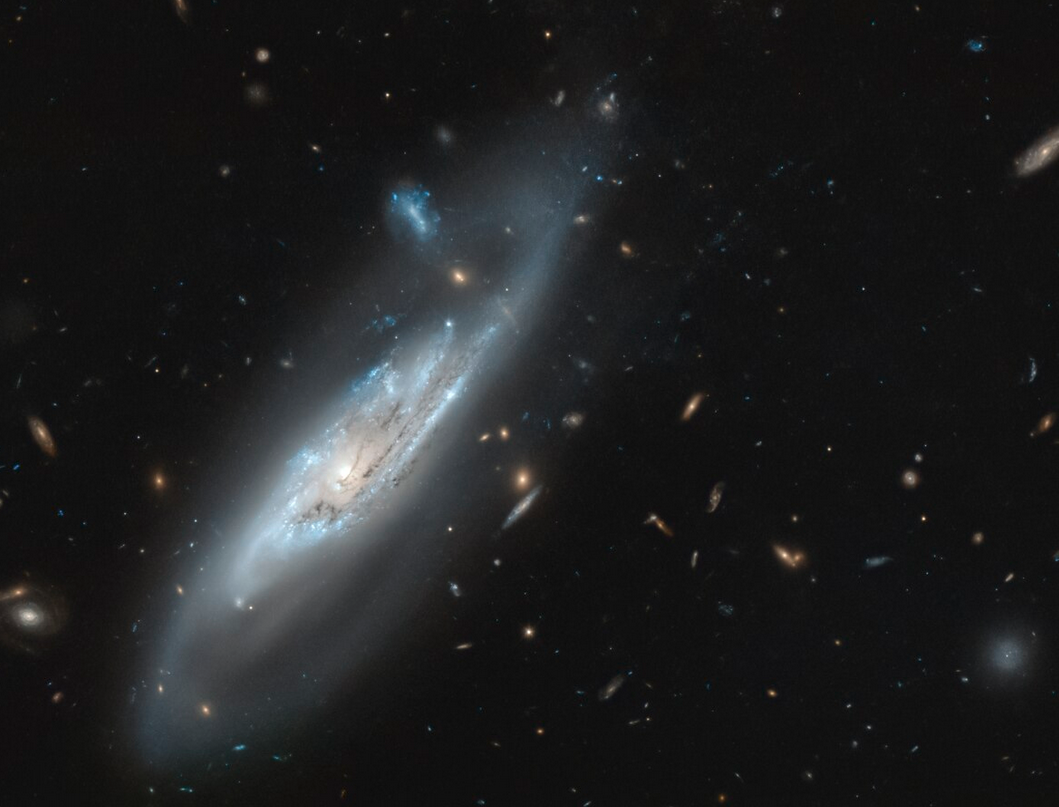

In [1]:
from astropy.io import fits
import numpy as np

with fits.open("DATA/NGC4848_cut.fits") as hdul:
    #hdul.info()
    #print(hdul[1].header)
    cube = hdul[1].data

channel = np.arange(0,3400,1)
w = 4750.15 + channel * 1.25   # wavelength in armstrong


In [2]:
# spectra adding all spatial pixels

summed_spectra = np.nansum(cube, axis=(1, 2))


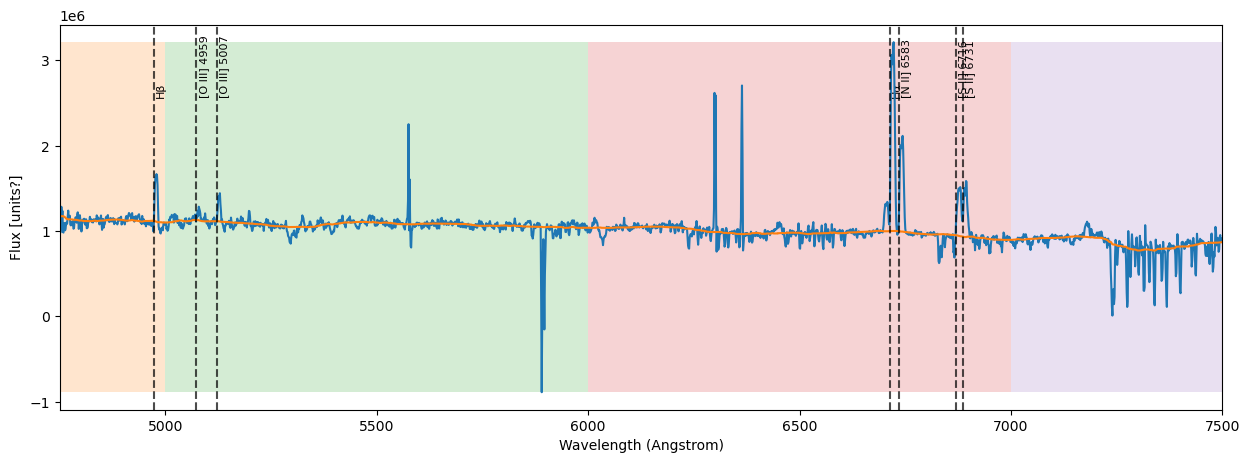

In [3]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(15,5))

plt.plot(w,summed_spectra)

from scipy.ndimage import median_filter
continuum = median_filter(summed_spectra, size=101,mode="nearest")  # Choose an odd kernel size
plt.plot(w,continuum)

plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux [units?]")

# Define UBVRI filter wavelength ranges (in Angstrom)
filters = {
    "U": (3200, 4000),
    "B": (4000, 5000),
    "V": (5000, 6000),
    "R": (6000, 7000),
    "I": (7000, 9000),
}

# Add vertical shaded regions corresponding to the filters
for name, (wmin, wmax) in filters.items():
    plt.fill_betweenx(
        [np.min(summed_spectra), np.max(summed_spectra)], 
        wmin, wmax, 
        alpha=0.2, label=f"{name} filter"
    )
    
z_Coma = 0.0231

# Define important emission/absorption lines in galaxies
spectral_lines = {
    "Lyα (Lyman-alpha)": 1216,
    "O II (Doublet)": 3727,
    "Hβ": 4861,
    "[O III] 4959": 4959,
    "[O III] 5007": 5007,
    "Hα": 6563,
    "[N II] 6583": 6583,
    "[S II] 6716": 6716,
    "[S II] 6731": 6731
}

# Apply redshift correction to each spectral line
redshifted_lines = {name: wavelength * (1 + z_Coma) for name, wavelength in spectral_lines.items()}

# Add vertical dashed lines for spectral features
for name, wavelength in redshifted_lines.items():
    plt.axvline(wavelength, color="black", linestyle="dashed", alpha=0.7)
    plt.text(wavelength + 5, np.max(summed_spectra) * 0.8, name, 
             rotation=90, verticalalignment="bottom", fontsize=8, zorder=1, clip_on=True)

plt.xlim(4750.15,7500)
#plt.xlim(6600,7000)

plt.show()


In [4]:
continuum_cube = np.zeros_like(cube)

# Apply median filter along the spectral axis (axis=0)
from tqdm.notebook import tqdm
for i in tqdm(range(cube.shape[1])):  
    for j in range(cube.shape[2]):  
        continuum_cube[:, i, j] = median_filter(cube[:, i, j], size=101, mode="nearest")

  0%|          | 0/395 [00:00<?, ?it/s]

In [8]:
# Convert wavelength range (5000-6000 and 6000-7000) to spectral indices
wavelengths = np.linspace(4750.15, 8998.9, cube.shape[0])  # Create wavelength array
v_band_indices = np.where((wavelengths >= 5000) & (wavelengths <= 6000))[0]
r_band_indices = np.where((wavelengths >= 6000) & (wavelengths <= 7000))[0]

V_map = np.sum(cube[v_band_indices, :, :], axis=0)
R_map = np.sum(cube[r_band_indices, :, :], axis=0)

# Sum along the spectral axis for V and R band maps for the continuum
V_map_continuum = np.sum(continuum_cube[v_band_indices, :, :], axis=0)
R_map_continuum = np.sum(continuum_cube[r_band_indices, :, :], axis=0)

# Emission lines map. Subtract continuum
V_map_lines = np.sum(cube[v_band_indices, :, :], axis=0) - V_map_continuum
R_map_lines = np.sum(cube[v_band_indices, :, :], axis=0) - R_map_continuum


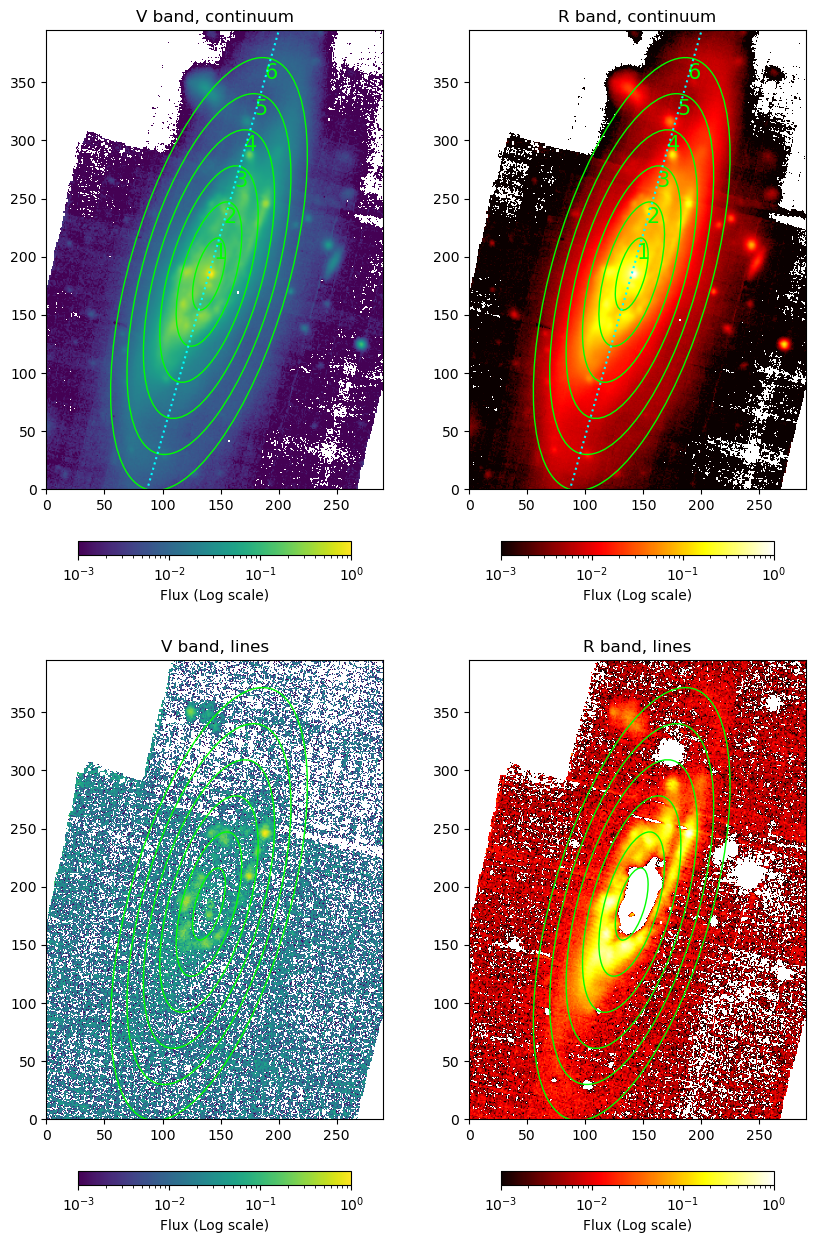

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(2, 2, figsize=(10, 15))
ax = ax.flatten()

ax[0].set_title("V band, continuum" )
ax[1].set_title("R band, continuum")
ax[2].set_title("V band, lines" )
ax[3].set_title("R band, lines")
im1 = ax[0].imshow(V_map_continuum/np.nanmax(V_map_continuum), origin='lower', cmap='viridis', norm=LogNorm(1e-3,1))
im2 = ax[1].imshow(R_map_continuum/np.nanmax(R_map_continuum), origin='lower', cmap='hot', norm=LogNorm(1e-3,1))
im3 = ax[2].imshow(V_map_lines/np.nanmax(V_map_lines), origin='lower', cmap='viridis', norm=LogNorm(1e-3,1))
im4 = ax[3].imshow(R_map_lines/np.nanmax(R_map_lines), origin='lower', cmap='hot', norm=LogNorm(1e-3,1))

# Add colorbars
fig.colorbar(im1, ax=ax[0], orientation='horizontal', label='Flux (Log scale)', pad=0.1, fraction=0.026)
fig.colorbar(im2, ax=ax[1], orientation='horizontal', label='Flux (Log scale)', pad=0.1, fraction=0.026)
fig.colorbar(im3, ax=ax[2], orientation='horizontal', label='Flux (Log scale)', pad=0.1, fraction=0.026)
fig.colorbar(im4, ax=ax[3], orientation='horizontal', label='Flux (Log scale)', pad=0.1, fraction=0.026)

# Add ellipses
center = (140, 185)  # Center of the ellipse (x, y)
angle = 74  # Angle of tilt in degrees

x = np.linspace(0,290)
m_semimajor_axis = np.tan(np.radians(angle))
y =  m_semimajor_axis * (x - center[0]) + center[1]
ax[0].plot(x,y,linestyle=':',c='cyan')
ax[1].plot(x,y,linestyle=':',c='cyan')

width = 450  # Width (major axis)
height = 160  # Height (minor axis)

n = 7

# Create ellipses and add them to the plot
for i in range(1, n):
    a = width*(1-(n-i)/n)
    b = height*(1-(n-i)/n)
    
    for k in range(2):
        ellipse = Ellipse(center, a, b, angle=angle, edgecolor='lime', facecolor='none')
        ax[k].add_patch(ellipse)
        x_text = center[0] + a/2 * np.cos(np.radians(angle)) - 5
        y_text = m_semimajor_axis * (x_text - center[0]) + center[1]
        ax[k].text(x_text,y_text, i, fontsize=15, zorder=1, clip_on=True,c='lime')
    for k in range(2,4):
        ellipse = Ellipse(center, a, b, angle=angle, edgecolor='lime', facecolor='none')
        ax[k].add_patch(ellipse)

for k in range(4):
    ax[k].set_xlim(0,V_map.shape[1])
    ax[k].set_ylim(0,V_map.shape[0])

plt.show()

In [24]:

# Create the list of empty lists to store pixel coordinates
elliptical_regions = [[] for i in range(1,n)]

# Loop through all pixels in V_map and check which ellipse they fall into
for x in range(V_map.shape[1]):  # Loop over X-axis (columns)
    for y in range(V_map.shape[0]):  # Loop over Y-axis (rows)

        # Transform (x, y) to the ellipse's coordinate system
        dx = (x - center[0]) * np.cos(np.radians(angle)) + (y - center[1]) * np.sin(np.radians(angle))
        dy = -(x - center[0]) * np.sin(np.radians(angle)) + (y - center[1]) * np.cos(np.radians(angle))

        # Check for each elliptical region
        for i in range(1, n):
            a = width*(1-(n-i)/n)
            b = height*(1-(n-i)/n)
            a_ = width*(1-(n-i+1)/n)
            b_ = height*(1-(n-i+1)/n)

            # Check if the pixel is within the current elliptical region (but outside the next smaller one)
            if (dx**2 / a**2 + dy**2 / b**2) <= 1 and (dx**2 / a_**2 + dy**2 / b_**2) > 1:
                elliptical_regions[i-1].append([x, y])


/tmp/ipykernel_9594/266892177.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  if (dx**2 / a**2 + dy**2 / b**2) <= 1 and (dx**2 / a_**2 + dy**2 / b_**2) > 1:
/tmp/ipykernel_9594/266892177.py:20: RuntimeWarning: invalid value encountered in scalar divide
  if (dx**2 / a**2 + dy**2 / b**2) <= 1 and (dx**2 / a_**2 + dy**2 / b_**2) > 1:


In [25]:
# Initialize a list to store the summed spectra for each elliptical region
summed_spectra_elliptical_regions = []

# Loop through each elliptical region
for i, region_coords in enumerate(elliptical_regions):
    # Create a mask for pixels within the current elliptical region
    mask = np.zeros((V_map.shape[0], V_map.shape[1]), dtype=bool)

    # Get the coordinates for the current elliptical region
    x_coords, y_coords = zip(*region_coords)

    # Set pixels within the elliptical region to True in the mask
    for x, y in zip(x_coords, y_coords):
        mask[y, x] = True  # Note the correct indexing (y, x)

    # Use the mask to select the corresponding pixels in the cube and sum the spectra
    region_spectrum = np.nansum(cube[:, mask], axis=1)  # Sum spectra for all masked pixels
    
    # Append the summed spectrum for the elliptical region
    summed_spectra_elliptical_regions.append(region_spectrum)


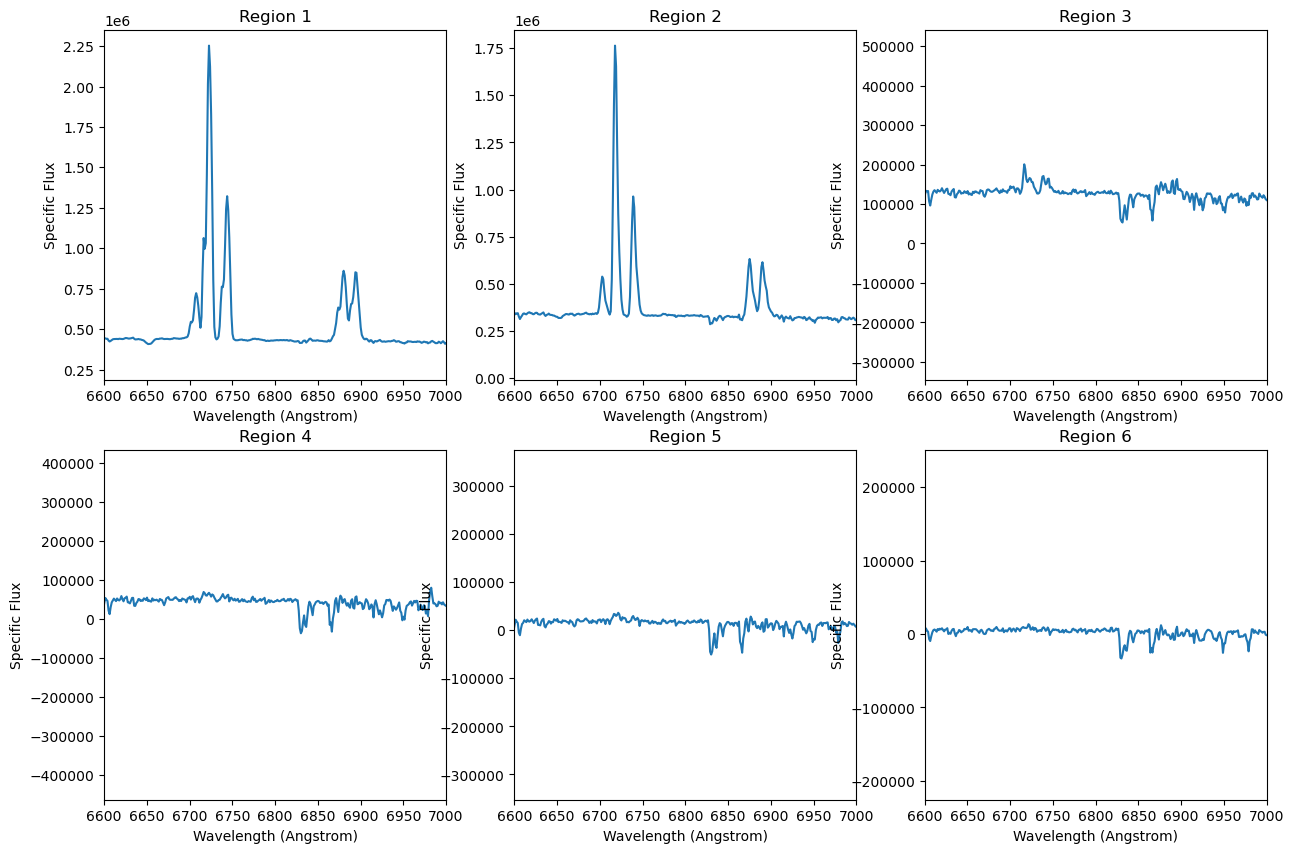

In [26]:
fig,ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()

for i in range(6):
    ax[i].plot(w,summed_spectra_elliptical_regions[i])
    ax[i].set_xlim(6600,7000)
    ax[i].set_xlabel("Wavelength (Angstrom)")
    ax[i].set_ylabel("Specific Flux")
    ax[i].set_title(f"Region {i+1}")

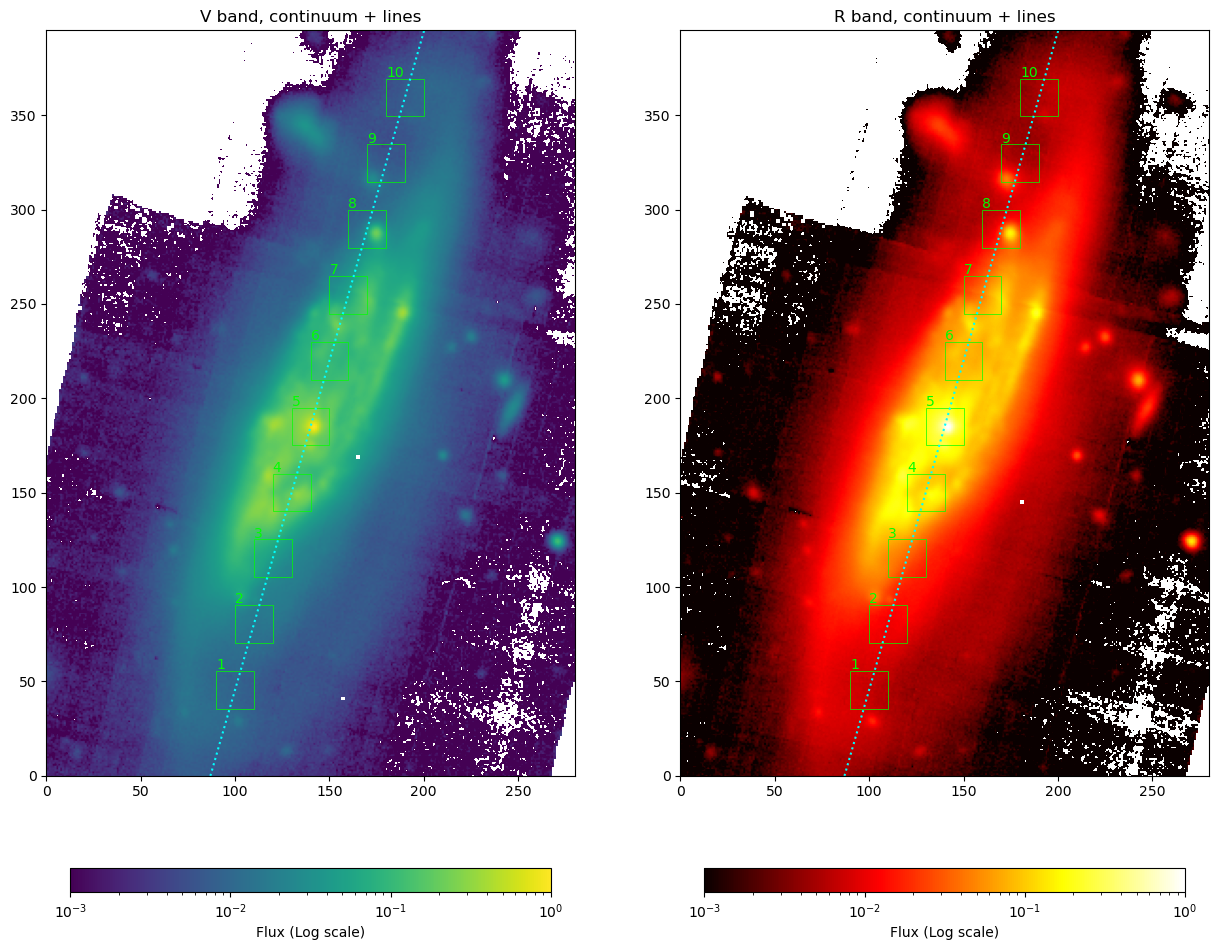

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15,12))

ax[0].set_title("V band, continuum + lines")
im1 = ax[0].imshow(V_map_continuum/np.nanmax(V_map_continuum), origin='lower', cmap='viridis', norm=LogNorm(1e-3,1))
fig.colorbar(im1, ax=ax[0], orientation='horizontal', label='Flux (Log scale)', pad=0.1, fraction=0.026)

ax[1].set_title("R band, continuum + lines")
im2 = ax[1].imshow(R_map_continuum/np.nanmax(R_map_continuum), origin='lower', cmap='hot', norm=LogNorm(1e-3,1))
fig.colorbar(im2, ax=ax[1], orientation='horizontal', label='Flux (Log scale)', pad=0.1, fraction=0.026)

x = np.linspace(0,290)
m_semimajor_axis = np.tan(np.radians(angle))
y =  m_semimajor_axis * (x - center[0]) + center[1]
ax[0].plot(x,y,c='cyan',linestyle=':')
ax[1].plot(x,y,c='cyan',linestyle=':')

squares = []
for i,x in enumerate(np.arange(100,200,10)):
    y =  m_semimajor_axis * (x - center[0]) + center[1]
    squares.append([x,y])
    for j in range(2):
        square = plt.Rectangle((x-10, y-10), 20, 20, fill=False, linewidth=0.5,color='lime')
        ax[j].add_patch(square)
        ax[j].text(x-10,y+11,i+1,c='lime')
        ax[j].set(xlim=(0,280),ylim=(0,395))


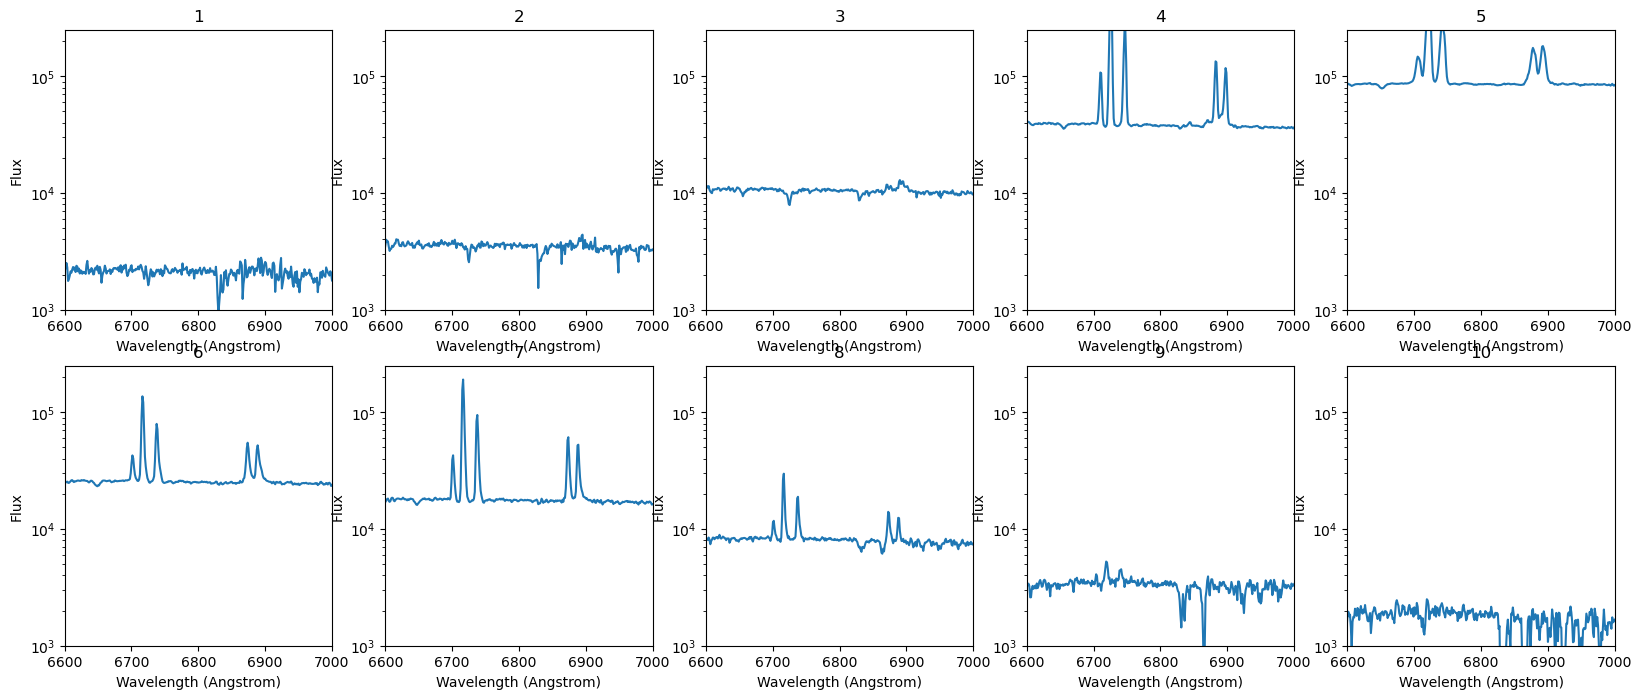

In [36]:
w = np.linspace(4750.15,8998.9,3400)

spectra = []
for p in squares:
    x, y = p[0], p[1]
    selected_pixels = cube[:,int(y-10):int(y+10),int(x-10):int(x+10)]
    summed_spectra = np.sum(selected_pixels, axis=(1, 2))
    spectra.append(summed_spectra)

fig, ax = plt.subplots(2,5,figsize=(20,8))
ax = ax.flatten()

for i in range(10):
    ax[i].plot(w, spectra[i])
    ax[i].set_title(i+1)
    ax[i].set_xlim(6600,7000)
    ax[i].set_ylim(1000,250000)
    ax[i].set_yscale("log")
    ax[i].set_xlabel("Wavelength (Angstrom)")
    ax[i].set_ylabel("Flux")

